## AIDI 2000 - Applied Machine Learning 
### Assignment 2 - Machine Translation

#### Michael Molnar (100806823)

For this assignment I will build an Encoder-Decoder deep learning model to perform machine translation from French to English.

Steps:
- Load and examine the dataset
- Perform pre-processing 
- Build and train the model
- Evaluate the model on the testing dataset 
- Examine the model's predictions on training and testing data
- Save the model and tokenizers
- Use the model to make predictions on new French sentences

#### Importing Necessary Libraries 

In [1]:
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed

from tensorflow.keras.models import load_model

#### Loading and Examining the Dataset

I will be working with the English - French dataset provided on the page, "Tab-delimited Bilingual Sentence Pairs", frm the Tatoeba Project.  The dataset is available for download at http://www.manythings.org/anki/.

In [3]:
# Load the dataset into memory
file = open('Data/fra.txt', mode='rt', encoding='utf-8')
text = file.read()
file.close()

From the notes on the website, the data is in the form: 

English + TAB + The Other Language + TAB + Attribution

I will keep only the first two elments - the English and French phrases.

In [4]:
# Split the data by line break 
lines = text.strip().split('\n')
# Split each line by tabs 
rows = [line.split('\t')[:2] for line in lines]

In [5]:
# View a couple rows
print(rows[:3])

[['Go.', 'Va !'], ['Go.', 'Marche.'], ['Go.', 'Bouge !']]


In [6]:
# View the last row
print(rows[-1])

["If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.", "Si quelqu'un qui ne connaît pas vos antécédents dit que vous parlez comme un locuteur natif, cela veut dire qu'il a probablement remarqué quelque chose à propos de votre élocution qui lui a fait prendre conscience que vous n'êtes pas un locuteur natif. En d'autres termes, vous ne parlez pas vraiment comme un locuteur natif."]


I can see that the first entry in each row is the English word or phrase, and the second entry is the French translation.  I can see the presence of capital letters and punctuations.  These, and other non-alphabetic characters, will be removed as part of the data pre-processing stage.  The phrases range from a single word to multiple sentences.

In [7]:
# Check the number of rows 
len(rows)

185583

There are over 185,000 sequence pairs in this dataset.  As I progressed through the code, I ran into memory issues due to the size.  As such, I will select the first 50,000 rows and use these for this assignment.  The length of sequences increases as you get further into the dataset, so these will be mostly shorter sequences.  

In [8]:
# Take only the first 50,000 rows
rows = rows[:50000]

#### Data Pre-Processing

In this section I will perform several operations to clean the text data.  First, I will split each sequence into tokens by splitting at white spaces.  Next, I will remove punctuations and non-alphabetic characters.  Finally, I will convert all text to lowercase. 

In [9]:
def clean_text(text):
    # Split the text into tokens at white spaces
    tokens = text.split()
    # Use regex to filter for punctuation
    no_punc = re.compile('[%s]'% re.escape(string.punctuation))
    # Remove the punctuation
    tokens = [no_punc.sub('', char) for char in tokens]
    # Remove any tokens that are non-alphabetic 
    tokens = [word for word in tokens if word.isalpha()]
    # Lowercase all text
    tokens = [word.lower() for word in tokens]
    return tokens

I will here split the data into the French phrases and the English, cleaning the text of each as I do so.

In [10]:
french = []
english = []
for row in rows:
    french.append(clean_text(row[1]))
    english.append(clean_text(row[0]))

Before moving further I will take a look at the data to see if any rows need to be removed.

In [11]:
# Create a DataFrame of the text
df = pd.DataFrame()
df['French'] = french
df['English'] = english

In [12]:
df.head(10)

,French,English
0,[va],[go]
1,[marche],[go]
2,[bouge],[go]
3,[salut],[hi]
4,[salut],[hi]
5,[cours],[run]
6,[courez],[run]
7,"[prenez, vos, jambes, à, vos, cous]",[run]
8,[file],[run]
9,[filez],[run]


In [13]:
# Check the lengths
df['French Length'] = df['French'].apply(lambda x: len(x))
df['English Length'] = df['English'].apply(lambda x: len(x))
df.head(10)

,French,English,French Length,English Length
0,[va],[go],1,1
1,[marche],[go],1,1
2,[bouge],[go],1,1
3,[salut],[hi],1,1
4,[salut],[hi],1,1
5,[cours],[run],1,1
6,[courez],[run],1,1
7,"[prenez, vos, jambes, à, vos, cous]",[run],6,1
8,[file],[run],1,1
9,[filez],[run],1,1


In [14]:
# Check for any missing rows
empty_fr = df[df['French Length'] == 0]
empty_eng = df[df['English Length'] == 0]

print(empty_fr)
print(empty_eng)

     French            English  French Length  English Length
468      []        [get, away]              0               2
6133     []  [am, i, approved]              0               3
Empty DataFrame
Columns: [French, English, French Length, English Length]
Index: []


In [15]:
# Drop rows with missing values
df = df[df['French Length'] != 0]

Next, I will split the text into the inputs, X, and outputs, y.

In [16]:
X = df['French'].values
y = df['English'].values

#### Preparing French and English Tokenizers

Next, I create two tokenizers - one for the English sequences and one for the French.  In this section I will save the vocabulary size (number of unique words) and the max sequence length for each of the two tokenizers.

In [17]:
# Prepare the French tokenizer
fra_tokenizer = Tokenizer()
fra_tokenizer.fit_on_texts(X)

In [18]:
# Check the size of French vocabulary
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('French vocabulary size:', fra_vocab_size)

French vocabulary size: 12582


In [19]:
# Get the maximum length of a sequence
fra_len = max(df['French Length'])
print('French max length:', fra_len)

French max length: 14


In [20]:
# Prepare the English tokenizer
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(y)

In [21]:
# Check the size of the English vocabulary
eng_vocab_size = len(eng_tokenizer.word_index) + 1
print('English vocabulary size:', eng_vocab_size)

English vocabulary size: 5986


In [26]:
# Get the maximum length of a sequence
eng_len = max(df['English Length'])
print('English max length:', eng_len)

English max length: 7


Next, I want to split the data into training and testing sets.  Then I want to convert the tokens into sequences and then pad each to match the maximum lenght.  For the output data, I want to use one-hot encoding to make these categorical.  To do these processes I will use two functions.

#### Splitting into Training and Testing Data

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [28]:
print('Size of X-train', X_train.shape)
print('Size of y-train', y_train.shape)
print('Size of X-test', X_test.shape)
print('Size of y-test', y_test.shape)

Size of X-train (39998,)
Size of y-train (39998,)
Size of X-test (10000,)
Size of y-test (10000,)


#### Encoding Sequences

In [29]:
def encode_sequences(tokenizer, length, text_tokens):
    """
    Here I will take the data that has been tokenized and convert the tokens
    into integers, using the pre-fit tokenizer.  Then, I will pad the lengths 
    of each sequence to match the maximum length.
    """
    # Encode sequences with integers
    enc_seq = tokenizer.texts_to_sequences(text_tokens)
    # Add 0's to the end of each to match the maximum length
    enc_seq = pad_sequences(enc_seq, maxlen=length, padding='post')
    return enc_seq

In [30]:
# Use this to enclode the X(French) and y(English) sequences
X_train = encode_sequences(fra_tokenizer, fra_len, X_train)
y_train = encode_sequences(eng_tokenizer, eng_len, y_train)

X_test = encode_sequences(fra_tokenizer, fra_len, X_test)
y_test = encode_sequences(eng_tokenizer, eng_len, y_test)

In [31]:
print('Size of X-train', X_train.shape)
print('Size of y-train', y_train.shape)
print('Size of X-test', X_test.shape)
print('Size of y-test', y_test.shape)

Size of X-train (39998, 14)
Size of y-train (39998, 7)
Size of X-test (10000, 14)
Size of y-test (10000, 7)


#### One-Hot Encoding Output Sequences

In [32]:
def encode_output(sequences, vocab_size):
    """
    One-hot encode the output (English sentences), using the to_categorical function
    where the number of classes is equal to the English vocabulary size from the fit
    tokenizer.  Then reshape as needed for use in the model.
    """
    y_list = []
    # Encode the sequences
    for sequence in sequences:
        one_hot = to_categorical(sequence, num_classes=vocab_size)
        y_list.append(one_hot)
    # Convert to numpy array
    y = np.array(y_list)
    # Reshape into three dimensions
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [33]:
# Use this function to encode the ouput sequences
y_train = encode_output(y_train, eng_vocab_size)
y_test = encode_output(y_test, eng_vocab_size)

In [34]:
print('Size of y-train', y_train.shape)
print('Size of y-test', y_test.shape)

Size of y-train (39998, 7, 5986)
Size of y-test (10000, 7, 5986)


#### Building the Encoder-Decoder Architecture 

I am now ready to build the model.  By limiting the size of the dataset I am working with, I have a sequence-to-sequence problem where both the input and output sequences are short.  As such I will make use of the Encoder-Decorder architecture, using the Long Short-Term Memory (LSTM) model.  There are many other options I could have tried here - including RNN, bidirectional models, and GRUs, as well as adding an Attention Mechanism.  For now I will proceed with this relatively simple model and evaluate how it performs on this task.

In [31]:
def define_model(input_vocab_size, output_vocab_size, input_seq_len, output_seq_len, mem_units):
    """
    Encoder-Decoder using LSTM model for a many-to-many sequence-to-sequence problem.
    """
    model = Sequential()
    model.add(Embedding(input_vocab_size, mem_units, input_length=input_seq_len))
    model.add(LSTM(mem_units))
    model.add(RepeatVector(output_seq_len))
    model.add(LSTM(mem_units, return_sequences=True))
    model.add(TimeDistributed(Dense(output_vocab_size, activation='softmax')))
    return model

In [32]:
# Define the model 
model = define_model(fra_vocab_size, eng_vocab_size, fra_len, eng_len, 256)
# Compile the model
# By one-hot-encoding the targets this is a classification - so I use the Adam
# optimizer and Categorical-crossentropy as the loss function 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 256)           3220992   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 256)            525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 5986)           1538402   
Total params: 5,810,018
Trainable params: 5,810,018
Non-trainable params: 0
_________________________________________________________________


#### Training the Model

In [34]:
# Fit the model 
# Store the history for evaluation purposes
model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
625/625 [==============================] - 87s 139ms/step - loss: 3.5148 - accuracy: 0.5030 - val_loss: 3.2799 - val_accuracy: 0.5120
Epoch 2/50
625/625 [==============================] - 85s 136ms/step - loss: 3.2387 - accuracy: 0.5111 - val_loss: 3.2330 - val_accuracy: 0.5120
Epoch 3/50
625/625 [==============================] - 85s 136ms/step - loss: 3.1970 - accuracy: 0.5112 - val_loss: 3.2139 - val_accuracy: 0.5120
Epoch 4/50
625/625 [==============================] - 84s 134ms/step - loss: 3.1769 - accuracy: 0.5112 - val_loss: 3.2088 - val_accuracy: 0.5120
Epoch 5/50
625/625 [==============================] - 85s 136ms/step - loss: 3.1648 - accuracy: 0.5113 - val_loss: 3.2054 - val_accuracy: 0.5120
Epoch 6/50
625/625 [==============================] - 85s 136ms/step - loss: 3.1572 - accuracy: 0.5112 - val_loss: 3.2042 - val_accuracy: 0.5120
Epoch 7/50
625/625 [==============================] - 85s 136ms/step - loss: 3.1517 - accuracy: 0.5112 - val_loss: 3.2008 - val_ac

In [36]:
# Store the model history for plotting purposes
histories = model.history.history

#### Evaluating the Model

Next, I will visualize the training and testing accuracies and losses.

In [37]:
def plot_training(histories):
    """
    Plot the accuracies and the categorical cross-entropy for training and testing, per epoch. 
    """
    # Convert to data frame for plotting purposes
    losses = pd.DataFrame(histories)
    fig = plt.figure(figsize=(15,5))
    # Plot the training and testing accuracy
    ax1 = fig.add_subplot(121)
    ax1.plot(losses['accuracy'], label='Training')
    ax1.plot(losses['val_accuracy'], label='Testing')
    ax1.set_title('Accuracy')
    ax1.legend()
    # Plot the training and testing categorical cross-entropy
    ax2 = fig.add_subplot(122)
    ax2.plot(losses['loss'], label='Training')
    ax2.plot(losses['val_loss'], label='Testing')
    ax2.set_title('Categorical Cross-Entropy')
    ax2.legend()
    plt.show()

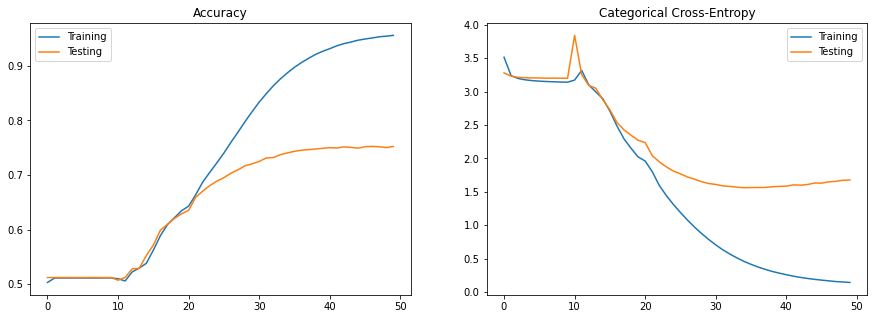

In [38]:
# Display the accuracy and loss over the 30 epochs
plot_training(histories)

I can see that the accuracy steadily increases from about the 10th epoch on both the training and testing datasets, before levelling off between the 30th and 40th epochs.  In terms of the loss function, the categorical cross-entropy, it decreases steadily on the training data, but on the test data it levels off around the 30th epoch and then starts to rise very slightly after about the 40th epoch.  This is a sign that the model is beginning to overfit at this point and will probably become worse if trained further.

In [39]:
# Evaluate the model on the test dataset
cce, acc = model.evaluate(X_test, y_test, verbose = 1)
print('Categorical Cross-Entropy on Test Dataset: {:.3f}'.format(cce))
print('Accuracy on Test Dataset: {:.2f} %'.format(acc*100))

313/313 [==============================] - 8s 25ms/step - loss: 1.6760 - accuracy: 0.7522
Categorical Cross-Entropy on Test Dataset: 1.676
Accuracy on Test Dataset: 75.22 %


The model is performing pretty well on the heldout test dataset.  Next, I will check predictions on some of the training and testing data.

#### Examining the Predictions

To see how the model is performing, I will need to use the tokenizers to convert the encoded integers back into the words.  The tokenizers' word indexes are dictionaries, where each unique word is represented by an integer.

In [35]:
def int_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [36]:
# Look at X_train[0]
X_train[0]

array([   8,   15,   16,  322, 4957,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

In [37]:
# Convert the integers found in the encoded input back into words
words = [int_to_word(x, fra_tokenizer) for x in X_train[0]]
# Stop when None appears
words = [word for word in words if word != None]
# Join into a sentence
' '.join(words)

'il a un nom commun'

Looking at the translation targets, the outputs were one-hot encoded with a vocabulary length of 5986, and each sequence was padded to a length of 7.  This means that the y-data will be 7 vectors, each of length 5986.  In each of these vectors there will be at most one 1, and the rest of the values will be 0 (there can be all 0s if the sequence does not contain the maximum 7 words).  So, by finding the index of this 1 we know the integer value for the word that exists in that place in the sequence, and with this we can extract the actual word from the tokenizer.

When it comes to making new predictions, probabilities will be generated for each of the 5986 possible words, and so finding the highest value within each of the 7 vectors will result in getting the word that is predicted to be most probable.

In [38]:
# Looking at y_train[0]
# For each of the 7 vectors, get the index of the highest value 
# This is the word that is predicted with the highest probability
integers = [np.argmax(vector) for vector in y_train[0]]
target = [] 
# For each of these, get the corresponding English word
for i in integers:
    word = int_to_word(i, eng_tokenizer)
    # Stop when reaching None
    if word is None:
        break
    target.append(word)

In [41]:
# Join into a sentence
' '.join(target)

'he has a common name'

In [42]:
# Making predictions and getting the proper shape
model.predict(X_train[0].reshape((1, X_train[0].shape[0])))[0]

array([[1.5799556e-09, 4.0273294e-06, 4.3033289e-11, ..., 1.2306751e-16,
        2.4679802e-12, 3.4404245e-13],
       [2.8297972e-11, 4.1107080e-11, 9.5728011e-16, ..., 3.6521611e-14,
        6.1111407e-12, 1.4697639e-14],
       [2.1003605e-07, 8.2900747e-10, 6.5587667e-13, ..., 4.3958184e-14,
        9.1868223e-13, 4.3484318e-12],
       ...,
       [3.6281035e-03, 1.0436039e-10, 3.5773648e-11, ..., 2.4086630e-13,
        2.8531240e-08, 2.4508446e-09],
       [9.4950610e-01, 6.5370501e-13, 2.1242491e-10, ..., 1.5350155e-16,
        1.4403184e-11, 2.1130122e-13],
       [9.9413896e-01, 5.3204362e-14, 1.9782613e-12, ..., 1.1604215e-18,
        8.9170961e-13, 8.9894599e-15]], dtype=float32)

After reshaping, the predictions are of the shape (7, 5986).  As explained above, the index of the highest value in each of the rows will correspond with the index of the predicted word in the tokenizer vocabulary. 

In [43]:
def get_translation(text):
    # Reshape text vector 
    text = text.reshape((1, text.shape[0]))
    # Make prediction
    prediction = model.predict(text, verbose=0)[0]
    # Get the integer indexes of the predicted words
    integers = [np.argmax(vector) for vector in prediction]
    # Convert this into a text sequence
    target = []
    for i in integers:
        word = int_to_word(i, eng_tokenizer)
        # Stop when the sequence hits the None padding
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

I will write two functions here using the above code - one to take a row of the dataset and return the French sentence, and the second to take a row of the data and return the actual English translation.

In [44]:
def get_french(row):
    # Get the words from the tokenizer
    words = [int_to_word(x, fra_tokenizer) for x in row]
    # Stop when None appears
    words = [word for word in words if word != None]
    return ' '.join(words)

In [45]:
def get_english(row):
    # Get word indexes
    integers = [np.argmax(vector) for vector in row]
    target = [] 
    for i in integers:
        # Retrieve words from the tokenizer
        word = int_to_word(i, eng_tokenizer)
        # Stop when None is appears
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

#### Examining Some of the Training Data

I will get 10 random rows of the training data and compare the predicted translations to the actual translations.

In [46]:
# Get the indexes of the training input 
X_train_index = range(len(X_train))
# Select 10 at random
index = list(random.sample(X_train_index, 10))
index

[22107, 18698, 15303, 26214, 19771, 1947, 32859, 36168, 31964, 32038]

In [50]:
# Compare the predictions to the actual translations
for i in index:
    print('Original French Sequence: ', get_french(X_train[i]))
    print('Actual English Translation: ', get_english(y_train[i]))
    print('Predicted English Translation: ', get_translation(X_train[i]))
    print('.......................')

Original French Sequence:  cest tout ce qua dit tom
Actual English Translation:  thats all tom said
Predicted English Translation:  thats all tom said
.......................
Original French Sequence:  jaime les fleurs des champs
Actual English Translation:  i like wild flowers
Predicted English Translation:  i like wild flowers
.......................
Original French Sequence:  cest terrifiant
Actual English Translation:  its terrifying
Predicted English Translation:  thats terrifying
.......................
Original French Sequence:  je veux les faits
Actual English Translation:  i want the facts
Predicted English Translation:  i want the facts
.......................
Original French Sequence:  cest tout ce que je fais ici
Actual English Translation:  thats all i do here
Predicted English Translation:  thats all i here here
.......................
Original French Sequence:  jespère seulement que tom va bien
Actual English Translation:  i just hope tom is ok
Predicted English Translat

Overall, on this random selection of the training data the predictions are extremely accurate and most are exactly correct.  There are a couple small variations (the word that's, in place of it's), and a situation where a word is incorrectly repeated (thats all i here here), but the model is performing very well on these.  Next, I will see how it performed on a random selection of the testing data.

#### Examining Some of the Testing Data

In [53]:
X_test_index = range(len(X_test))
index2 = list(random.sample(X_test_index, 10))
index2

[4774, 2625, 4009, 3353, 6631, 815, 3398, 567, 9637, 501]

In [54]:
for i in index2:
    print('Original French Sequence: ', get_french(X_test[i]))
    print('Actual English Translation: ', get_english(y_test[i]))
    print('Predicted English Translation: ', get_translation(X_test[i]))
    print('.......................')

Original French Sequence:  tu as parfaitement raison
Actual English Translation:  youre totally right
Predicted English Translation:  youre quite right
.......................
Original French Sequence:  je nai pas dit ça
Actual English Translation:  i didnt say that
Predicted English Translation:  i didnt say that
.......................
Original French Sequence:  le train est en avance
Actual English Translation:  the train is early
Predicted English Translation:  the trains early
.......................
Original French Sequence:  cétait moins une
Actual English Translation:  it was really close
Predicted English Translation:  that was close
.......................
Original French Sequence:  estce un cerf
Actual English Translation:  is it a deer
Predicted English Translation:  is that a deer
.......................
Original French Sequence:  jexpliquerai
Actual English Translation:  ill explain
Predicted English Translation:  ill love
.......................
Original French Sequence:

In this random selection there is quite a ranage in the accuracy of the predictions.  Some are exactly correct, some are mostly correct with some variation that still makes sense (for example, the word "concerned" being predicted instead of "worried"), and some are very, very wrong.  

Now I will show how the model and tokenizers can be saved and then loaded to make predictions on brand new French text.

#### Saving the Model and Tokenizers

In [47]:
# Save the model
model.save('fra_to_eng.h5')

In [48]:
# Save the tokenizers
pickle.dump(fra_tokenizer, open('fra_tokenizer.pkl', 'wb'))
pickle.dump(eng_tokenizer, open('eng_tokenizer.pkl', 'wb'))

#### Translating New French Sentences

To use my model to translate new text, I will take French input, pre-process it following what I did with the data the model was trained on, and then follow the same steps as before - tokenizing, padding, and then predicting. 

Here I test a very simple input, "Je suis heureux", or, "I am happy".

In [49]:
fra_input = 'Je suis heureux'

In [50]:
# Clean the text using the same function I used on the dataset
clean_fra_input = clean_text(fra_input)
clean_fra_input

['je', 'suis', 'heureux']

In [51]:
# Load the tokenizers
fra_tokenizer = pickle.load(open('fra_tokenizer.pkl', 'rb'))
eng_tokenizer = pickle.load(open('eng_tokenizer.pkl', 'rb'))

As before, this input must be tokenized and padded to match the maximum length of the input (which was 14 words).

In [57]:
# Use the French tokenizer to encode the input text 
encoded_input = fra_tokenizer.texts_to_sequences(clean_fra_input)
encoded_input

[[1], [12], [159]]

I want to convert this into a Numpy array, and pad its length to match the maximum French sequence length of 14.

In [58]:
# Create a list of the integers
encoded_input = [i[0] for i in encoded_input]
encoded_input

[1, 12, 159]

In [59]:
# Pad with 0's until it matches the proper length of 14 tokens
while len(encoded_input) < 14:
    encoded_input.append(0)
# Convert to a Numpy array
encoded_input = np.array(encoded_input)
encoded_input

array([  1,  12, 159,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0])

This now matches the training and testing data and is ready for predictions.

In [60]:
# Load the model
model = load_model('fra_to_eng.h5')

In [61]:
# Get the translation
translation = get_translation(encoded_input)
translation

'im happy'

It works on this very very short and common phrase.  I will combined these steps now into a translation function to see how the model performs on various sorts of inputs.  This will be done in a standalone notebook.  

### *** Please see "french_to_english.ipynb' that follows for the completition of my assignment submission.

#### Conclusions

My model performs well on the training data and input sequences that are short and common phrases (see the notebook that follows for further predictions on new text).  There is a lot of room for improvement here.  An attention mechanism is something that can be added to this model to make it better.  I can increase the depths of the encoder and decoder.  Also, I can make use of the concept of the beam search to improve the accuracy of the decoder. 


Furthermore, by limiting the dataset as I did at the outset of this notebook I am only training my model on short phrases.  This can be seen by the fact that the longest English phrase is only seven words long.  I can improve the model by increasing both the length and diversity of the training data sequences.  I notice that there are words, such as my name, Michael, for example, that do not exist in the training dataset.  Although this is a proper name, I would be interested to explore the tokenizer's vocabulary list further and see if there are further limitations in it.

Overall, the model performs great on short and common phrases.

#### References

Brownlee J.  How to Develop a Neural Machine Translation System from Scratch.  Machine Learning Mastery.  https://machinelearningmastery.com/develop-neural-machine-translation-system-keras/.  Published January 10, 2018.  Accessed March 23, 2021.

Brownlee J.  How to Configure an Encoder-Decoder Model for Neural Machine Translation.  Machine Learning Mastery.  https://machinelearningmastery.com/configure-encoder-decoder-model-neural-machine-translation/.  Published January 3, 2018.  Accessed March 23, 2021.